# 0.0. Imports

In [124]:
import os
import re
#import s3fs
import joblib
import pickle
import numpy      as np
import pandas     as pd
import seaborn    as sns
import umap.umap_ as umap


from plotly          import express as px
from matplotlib      import pyplot as plt

from sklearn import cluster       as c
from sklearn import metrics       as m
from sklearn import mixture       as mx
from sklearn import ensemble      as en
from sklearn import manifold      as mn
from sklearn import preprocessing as pp
from sklearn import decomposition as dd
from sklearn.neighbors import NearestNeighbors

from scipy.cluster import hierarchy as hc

import warnings
# Suprimir FutureWarnings do scikit-learn
warnings.simplefilter(action='ignore', category=FutureWarning)


## 0.2. Load dataset

In [125]:
# Carregar os dados brutos de um arquivo CSV com a codificação especificada
df_raw = pd.read_csv('../data/raw/Ecommerce.csv', encoding='ISO-8859-1')

# Remover uma coluna extra 'Unnamed: 8'
df_raw = df_raw.drop(columns=['Unnamed: 8'], axis=1)

# 1.0. Descrição dos dados

In [126]:
df1 = df_raw.copy()

In [127]:
df1.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


## 1.1. Rename columuns

In [128]:
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']
df1.columns = cols_new

## 1.2. Data dimensions

In [129]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of cols: {}'.format(df1.shape[1]))

Number of rows: 541909
Number of cols: 8


## 1.3. Data types

In [130]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4. Check NA

In [131]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5. Replace NA

In [132]:
# Filtrar as linhas com 'customer_id' ausente (NaN)
df_missing = df1.loc[df1['customer_id'].isna(), :]

# Filtrar as linhas com 'customer_id' presente
df_not_missing = df1.loc[~df1['customer_id'].isna(), :]


In [133]:
# Criar um DataFrame de referência para 'customer_id'
df_backup = pd.DataFrame(df_missing['invoice_no'].drop_duplicates())

# Atribuir IDs únicos começando em 19000 para cada fatura ausente
df_backup['customer_id'] = np.arange(19000, 19000 + len(df_backup), 1)

# Mesclar o DataFrame original com o DataFrame de referência usando 'invoice_no' como chave
df1 = pd.merge(df1, df_backup, on='invoice_no', how='left')

# Combinar os valores de 'customer_id_x' e 'customer_id_y', mantendo o primeiro valor não nulo encontrado
df1['customer_id'] = df1['customer_id_x'].combine_first(df1['customer_id_y'])

# Remover as colunas 'customer_id_x' e 'customer_id_y'
df1 = df1.drop( columns=['customer_id_x', 'customer_id_y'], axis=1)


In [134]:
df1.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

## 1.6. Change dtypes

In [135]:
# Converter a coluna 'invoice_date' para um formato de data com um formato de data específico
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format='%d-%b-%y')

# Converter a coluna 'customer_id' para números inteiros
df1['customer_id'] = df1['customer_id'].astype(int)
df1.head()


,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,United Kingdom,17850
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,United Kingdom,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,United Kingdom,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,United Kingdom,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,United Kingdom,17850


In [136]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int64
dtype: object

## 1.7. Descriptive Statistics

In [137]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

### 1.7.1. Numerical Attributs


In [138]:
# Central tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - desvio padrão, mínimo, máximo, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(np.min)).T
d3 = pd.DataFrame(num_attributes.apply(np.max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concatenate
m1 = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m1.columns = ['attributes', 'min', 'max', 'range', 'mean', 'mediana', 'std', 'skew', 'kurtosis']
m1

,attributes,min,max,range,mean,mediana,std,skew,kurtosis
0,quantity,-80995.00,80995.0,161990.00,9.552250,3.00,218.080957,-0.264076,119769.160031
1,unit_price,-11062.06,38970.0,50032.06,4.611114,2.08,96.759764,186.506972,59005.719097
2,customer_id,12346.00,22709.0,10363.00,16688.840453,16249.00,2911.408666,0.487449,-0.804287


### 1.7.2. Categorical Attributs

#### Invoice No


In [139]:
# Problema: Temos invoice com letras e números
# df1['invoice_no'].astype(int)

# Identificação:
df_letter_invoices = df1.loc[df1['invoice_no'].apply(lambda x: bool(re.search('[^0-9]+', x))), :]
df_letter_invoices.head()

print('Total number of invoices: {}'.format(len(df_letter_invoices)))
print('Total number of negative quantity: {}'.format(len(df_letter_invoices[df_letter_invoices['quantity'] < 0])))


Total number of invoices: 9291
Total number of negative quantity: 9288


#### Stock Code

In [140]:
# Verifique apenas os caracteres em stock code
df1.loc[df1['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))), 'stock_code'].unique()

# Ação:
## 1. Remove stock_code in ['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK']

array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

#### Description

In [141]:
df1.head()

# Acão: 
# 1. Deletar description

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,United Kingdom,17850
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,United Kingdom,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,United Kingdom,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,United Kingdom,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,United Kingdom,17850


#### Country

In [142]:
df1['country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

In [143]:
# Apresenta a contagem de ocorrências de cada país no DataFrame 'df1', normalizada.
df1['country'].value_counts(normalize=True).head()


country
United Kingdom    0.914320
Germany           0.017521
France            0.015790
EIRE              0.015124
Spain             0.004674
Name: proportion, dtype: float64

In [144]:
# Conta o número de clientes únicos por país, mostrando os países com mais clientes.
df1[['customer_id', 'country']].drop_duplicates().groupby('country').count().reset_index().sort_values('customer_id', ascending=False).head()


,country,customer_id
36,United Kingdom,7587
14,Germany,95
13,France,90
10,EIRE,44
31,Spain,31


# 2.0. Filtragem de Varivéis 

In [145]:
df2 = df1.copy()

In [146]:
df2.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int64
dtype: object

In [147]:
# Filtrando dados numéricos
df2 = df2.loc[df2['unit_price'] >= 0.04, :]

# Filtrando dados categóricos
df2 = df2[~df2['stock_code'].isin(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK'])]

# Removendo a coluna 'description'
df2 = df2.drop(columns='description', axis=1)

# Filtrando valores do país 
df2 = df2[~df2['country'].isin(['European Community', 'Unspecified'])]

# bad users
df2 = df2[~df2['customer_id'].isin([16446])]

# Separando compras e devoluções com base na quantidade ('quantity')
df2_returns = df2.loc[df1['quantity'] < 0, :]
df2_purchases = df2.loc[df1['quantity'] >= 0, :]

# 3.0. Feature Engineering 

In [148]:
df3 = df2.copy()

## 3.1. Feature Creation

In [149]:
# Criando um DataFrame de referência ('df_ref') com base em outras colunas
df_ref = df3.drop(['invoice_no', 'stock_code', 'quantity', 'invoice_date', 'unit_price', 'country'], axis=1).drop_duplicates(ignore_index=True)


In [150]:
df_ref.shape

(5786, 1)

### 3.1.1. Gross Revenue

In [151]:
# Calculando a receita bruta ('gross_revenue') multiplicando quantidade ('quantity') pelo preço unitário ('unit_price')
df2_purchases.loc[:, 'gross_revenue'] = df2_purchases.loc[:, 'quantity'] * df2_purchases.loc[:, 'unit_price']


# Calculando o valor monetário total por cliente ('df_monetary')
df_monetary = df2_purchases.loc[:, ['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df_monetary, on='customer_id', how='left')
df_ref.isna().sum()

/var/folders/x1/pk89dqcx2jgg4h8p2wtym9780000gn/T/ipykernel_19120/3977924132.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_purchases.loc[:, 'gross_revenue'] = df2_purchases.loc[:, 'quantity'] * df2_purchases.loc[:, 'unit_price']


customer_id       0
gross_revenue    91
dtype: int64

### 3.1.2. Recency - Day from last purchase


In [152]:
# Calculando a recência ('recency') com base na última data de compra
df_recency = df2_purchases.loc[:, ['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df2['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge(df_ref, df_recency, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
dtype: int64

### 3.1.3. Quantity of purchased 


In [153]:
# Cálculo da quantidade de faturas únicas
df_freq = (df2_purchases.loc[:, ['customer_id', 'invoice_no']].drop_duplicates()
                                                             .groupby( 'customer_id' )
                                                             .count()
                                                             .reset_index()
                                                             .rename(columns={'invoice_no': 'qtde_invoices'}) )
df_ref = pd.merge(df_ref, df_freq, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
dtype: int64

### 3.1.4. Quantity total of items purchased 


In [154]:
# Soma da quantidade de itens comprados
df_freq = (df2_purchases.loc[:, ['customer_id', 'quantity']].groupby('customer_id' ).sum()
                                                           .reset_index()
                                                           .rename(columns={'quantity': 'qtde_items'}))
df_ref = pd.merge(df_ref, df_freq, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
qtde_items       91
dtype: int64

### 3.1.5. Quantity of products purchased

In [155]:
# Numero de produtos
df_freq = (df2_purchases.loc[:, ['customer_id', 'stock_code']].groupby('customer_id').count()
                                                           .reset_index()
                                                           .rename(columns={'stock_code': 'qtde_products'}))
df_ref = pd.merge(df_ref, df_freq, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
qtde_items       91
qtde_products    91
dtype: int64

### 3.1.6. Average Ticket Value 


In [156]:
# Ticket médio
df_avg_ticket = df2_purchases.loc[:, ['customer_id', 'gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue':'avg_ticket'})
df_ref = pd.merge(df_ref, df_avg_ticket, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
qtde_items       91
qtde_products    91
avg_ticket       91
dtype: int64

### 3.1.7. Average Recency Days 


In [157]:
# Média dos dias de recência

df_aux = df2[['customer_id', 'invoice_date']].drop_duplicates().sort_values( ['customer_id', 'invoice_date'], ascending=[False, False] )
df_aux['next_customer_id'] = df_aux['customer_id'].shift() # next customer
df_aux['previous_date'] = df_aux['invoice_date'].shift() # next invoince date

df_aux['avg_recency_days'] = df_aux.apply(lambda x: ( x['invoice_date'] - x['previous_date'] ).days if x['customer_id'] == x['next_customer_id'] else np.nan, axis=1 )

df_aux = df_aux.drop(['invoice_date', 'next_customer_id', 'previous_date'], axis=1 ).dropna()

# average recency 
df_avg_recency_days = df_aux.groupby('customer_id').mean().reset_index()

# merge
df_ref = pd.merge(df_ref, df_avg_recency_days, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_items            91
qtde_products         91
avg_ticket            91
avg_recency_days    2816
dtype: int64

### 3.1.8. Frequency Purchase 


In [158]:
# Frequência
df_aux = (df2_purchases[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates()
                                                             .groupby( 'customer_id')
                                                             .agg( max_ = ( 'invoice_date', 'max' ), 
                                                                   min_ = ( 'invoice_date', 'min' ),
                                                                   days_= ( 'invoice_date', lambda x: ( ( x.max() - x.min() ).days ) + 1 ),
                                                                   buy_ = ( 'invoice_no', 'count' ) ) ).reset_index()
# Frequency
df_aux['frequency'] = df_aux[['buy_', 'days_']].apply( lambda x: x['buy_'] / x['days_'] if  x['days_'] != 0 else 0, axis=1 )

# Merge
df_ref = pd.merge(df_ref, df_aux[['customer_id', 'frequency']], on='customer_id', how='left' )

df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_items            91
qtde_products         91
avg_ticket            91
avg_recency_days    2816
frequency             91
dtype: int64

### 3.1.9. Number of Returns 


In [159]:
# Número de Devoluções
df_returns = df2_returns[['customer_id', 'quantity']].groupby( 'customer_id' ).sum().reset_index().rename( columns={'quantity':'qtde_returns'} )
df_returns['qtde_returns'] = df_returns['qtde_returns'] * -1

df_ref = pd.merge( df_ref, df_returns, how='left', on='customer_id' )
df_ref.loc[df_ref['qtde_returns'].isna(), 'qtde_returns'] = 0

df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_items            91
qtde_products         91
avg_ticket            91
avg_recency_days    2816
frequency             91
qtde_returns           0
dtype: int64

# 4.0. EDA (Exploratory Data Analysis)

In [160]:
df4 = df_ref.dropna()

## 4.3. Estudo do Espaço


In [161]:

# selected dataset
cols_selected = ['customer_id', 'gross_revenue', 'recency_days', 'qtde_products', 'frequency', 'qtde_returns']
df43 = df4[cols_selected].drop(columns='customer_id', axis=1)

In [162]:
mm = pp.MinMaxScaler()

# Aplicando a escala Min-Max a colunas específicas do DataFrame df43
# Isso irá dimensionar os valores de cada coluna para o intervalo entre 0 e 1

df43['gross_revenue']          = mm.fit_transform( df43[['gross_revenue']] )
df43['recency_days']           = mm.fit_transform( df43[['recency_days']] )
df43['qtde_products']          = mm.fit_transform( df43[['qtde_products']])
df43['frequency']              = mm.fit_transform( df43[['frequency']])
df43['qtde_returns']           = mm.fit_transform( df43[['qtde_returns']])

X = df43.copy()

In [163]:
X.shape

(2968, 5)

### 4.3.1. PCA


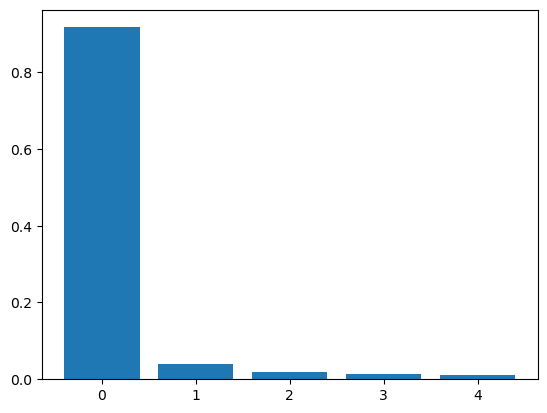

In [164]:
# Criando uma instância do PCA com o número de componentes igual ao número de colunas
pca = dd.PCA(n_components=X.shape[1])

# Aplicando a análise de componentes principais ao DataFrame X
principal_components = pca.fit_transform(X)

# Preparando um gráfico de barras para mostrar a variância explicada por cada componente principal
features = range(pca.n_components_)

# Criando um gráfico de barras das variâncias explicadas por cada componente
plt.bar(features, pca.explained_variance_ratio_)

# Criando um DataFrame df_pca para armazenar os resultados da análise de componentes principais
df_pca = pd.DataFrame(principal_components)

<Axes: xlabel='0', ylabel='1'>

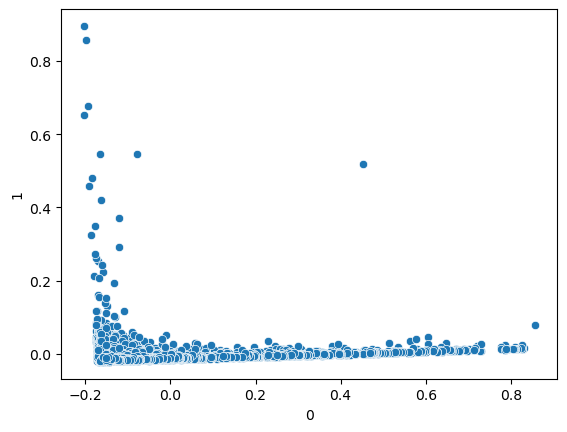

In [165]:
sns.scatterplot(x=0, y=1, data=df_pca)

### 4.3.2. UMAP


<Axes: xlabel='embedding_x', ylabel='embedding_y'>

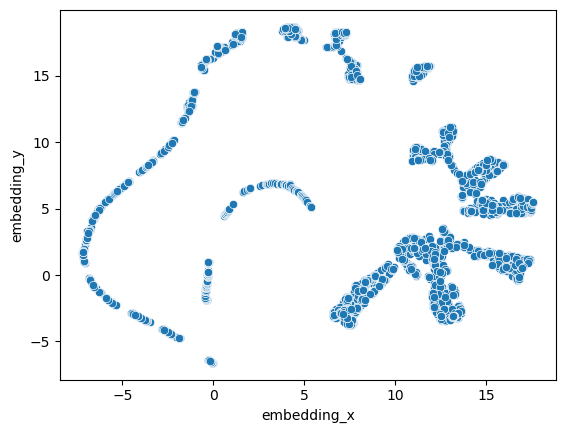

In [166]:
# Cria uma instância do reduzidor UMAP (Uniform Manifold Approximation and Projection)
reducer = umap.UMAP(random_state=42)

# Realiza a redução de dimensionalidade UMAP nos dados em X
embedding = reducer.fit_transform(X)

# Adiciona as coordenadas de embedding aos dados do DataFrame df_pca
df_umap = pd.DataFrame()
df_umap['embedding_x'] = embedding[:, 0]
df_umap['embedding_y'] = embedding[:, 1]

# Plota os dados no espaço UMAP usando seaborn
sns.scatterplot(x='embedding_x', y='embedding_y', data=df_umap)


### 4.3.2. t-SNE


<Axes: xlabel='embedding_x', ylabel='embedding_y'>

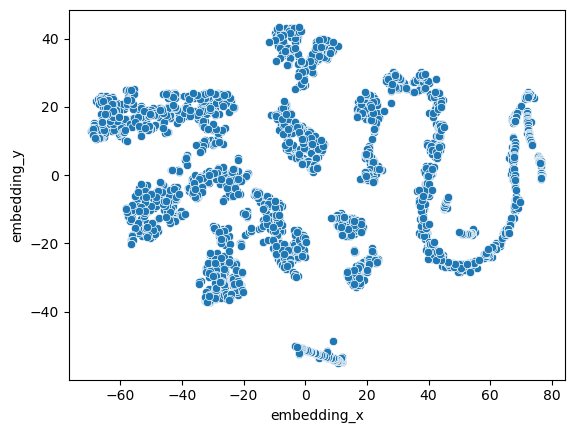

In [167]:
# Cria uma instância do reduzidor t-SNE (t-Distributed Stochastic Neighbor Embedding)
reducer = mn.TSNE(n_components=2, n_jobs=-1, random_state=42)

# Realiza a redução de dimensionalidade t-SNE nos dados em X
embedding = reducer.fit_transform(X)

# Adiciona as coordenadas de embedding aos dados do DataFrame df_pca
df_tsne = pd.DataFrame()
df_tsne['embedding_x'] = embedding[:, 0]
df_tsne['embedding_y'] = embedding[:, 1]

# Plota os dados no espaço t-SNE usando seaborn
sns.scatterplot(x='embedding_x', y='embedding_y', data=df_tsne)


### 4.3.3. Tree-Based Embedding

In [168]:
# Define o conjunto de treinamento, onde X é o conjunto de recursos e y é a variável de destino
X = df43.drop(columns=['gross_revenue'], axis=1)
y = df43['gross_revenue']

# Define o modelo de regressão de floresta aleatória com 100 estimadores e uma semente aleatória de 42
rf_model = en.RandomForestRegressor(n_estimators=100, random_state=42)

# Treina o modelo de regressão de floresta aleatória com os dados de treinamento
rf_model.fit(X, y)

# Leaf 
# Cria um DataFrame chamado "df_leaf" que contém as previsões de folhas do modelo de regressão de floresta aleatória para os dados de treinamento
# O método "apply" retorna o índice de folha de cada amostra no modelo
df_leaf = pd.DataFrame(rf_model.apply(X))

# dataframe Leaf

In [169]:
# Reduz a dimensionalidade usando UMAP
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(df_leaf)

# Cria as colunas 'embedding_x' e 'embedding_y' no DataFrame df_tree para representar a redução de dimensionalidade UMAP
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:, 0]
df_tree['embedding_y'] = embedding[:, 1]

# Plota um gráfico UMAP com as coordenadas 'embedding_x' e 'embedding_y' usando seaborn
#sns.scatterplot(x='embedding_x', y='embedding_y', data=df_tree)


# 5.0. Data Preparation 

In [170]:
# Tree-Based Embedding
df5 = df_tree.copy()

# UMAP Embedding
#df5 = df_umap.copy()

# TSNE Embedding
#df5 = df_tsne.copy()

# 7.0. Hyperparameter Fine-Tunning

In [171]:

X = df5.copy()


In [172]:
X.head()

,embedding_x,embedding_y
0,9.580960,15.718475
1,18.531776,8.094697
2,8.426165,15.730021
3,-1.896095,2.566201
4,-4.975142,10.840221


In [173]:
#clusters = [2, 3, 4, 5, 6, 7]

clusters = np.arange(2, 25, 1)

## 7.1. K-Means

In [174]:
kmeans_list = []
for k in clusters:
    # model definition
    kmeans_model = c.KMeans(n_clusters=k, n_init=300, random_state=42)

    # model training
    kmeans_model.fit(X)

    # model predict
    labels = kmeans_model.predict(X)

    # model performance
    # Calcula o coeficiente de silhueta para a atual clusterização
    sil = m.silhouette_score(X, labels, metric='euclidean')
    kmeans_list.append(sil)

## 7.2. GMM

In [175]:
gmm_list = []
for k in clusters:
    # model definition
    gmm_model = mx.GaussianMixture(n_components=k, n_init=10, random_state=42)
    
    # model training
    gmm_model.fit(X)

    # model predict
    labels = gmm_model.predict(X)

    # model performance
    sil = m.silhouette_score(X, labels, metric='euclidean')
    gmm_list.append(sil)

## 7.3. Hierarchical Clustering

In [176]:
hc_list = []
for k in clusters:
    # model definition & training
    hc_model = hc.linkage(X, 'average')

    # model predict
    labels = hc.fcluster(hc_model, k, criterion='maxclust')

    # metrics
    sil = m.silhouette_score(X, labels, metric='euclidean')
    hc_list.append(sil)

## 7.5. Results

### 7.5.1. Tree Based Embedding


In [177]:
# Cria um DataFrame de resultados para comparar os coeficientes de silhueta
# entre diferentes algoritmos de clustering e números de clusters.

df_results = pd.DataFrame(
    {'KMeans': kmeans_list,
     'GMM': gmm_list,
     'HC': hc_list,
     }
).T

# Define os nomes das colunas como os números de clusters
df_results.columns = clusters

# Realça o valor máximo em cada linha
df_results.style.highlight_max(color='lightblue', axis=1)

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
KMeans,0.392439,0.488181,0.521269,0.533298,0.572919,0.620096,0.623568,0.633565,0.649349,0.671341,0.692728,0.700931,0.682844,0.696594,0.695232,0.708160,0.688546,0.671381,0.648823,0.659310,0.656118,0.658228,0.650952
GMM,0.394694,0.454610,0.503715,0.526802,0.527993,0.573982,0.573620,0.650413,0.669947,0.670343,0.653631,0.663404,0.684434,0.681079,0.646050,0.707923,0.674977,0.694722,0.658214,0.637364,0.648207,0.645855,0.654541
HC,0.330073,0.483587,0.511364,0.529699,0.553966,0.620096,0.628532,0.625868,0.649600,0.650535,0.679544,0.700931,0.714682,0.692797,0.712598,0.707975,0.690799,0.672614,0.674313,0.683689,0.682773,0.679652,0.660414


### 7.5.2. UMAP Embedding

In [178]:
df_results = pd.DataFrame( 
    {'KMeans': kmeans_list, 
     'GMM': gmm_list, 
     'HC': hc_list}
).T

df_results.columns = clusters
df_results.style.highlight_max( color='lightgreen', axis=1 )

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
KMeans,0.392439,0.488181,0.521269,0.533298,0.572919,0.620096,0.623568,0.633565,0.649349,0.671341,0.692728,0.700931,0.682844,0.696594,0.695232,0.708160,0.688546,0.671381,0.648823,0.659310,0.656118,0.658228,0.650952
GMM,0.394694,0.454610,0.503715,0.526802,0.527993,0.573982,0.573620,0.650413,0.669947,0.670343,0.653631,0.663404,0.684434,0.681079,0.646050,0.707923,0.674977,0.694722,0.658214,0.637364,0.648207,0.645855,0.654541
HC,0.330073,0.483587,0.511364,0.529699,0.553966,0.620096,0.628532,0.625868,0.649600,0.650535,0.679544,0.700931,0.714682,0.692797,0.712598,0.707975,0.690799,0.672614,0.674313,0.683689,0.682773,0.679652,0.660414


### 7.5.3. TSNE Embedding


In [179]:
df_results = pd.DataFrame( 
    {'KMeans': kmeans_list, 
     'GMM': gmm_list, 
     'HC': hc_list}
).T

df_results.columns = clusters
df_results.style.highlight_max( color='lightgreen', axis=1 )

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
KMeans,0.392439,0.488181,0.521269,0.533298,0.572919,0.620096,0.623568,0.633565,0.649349,0.671341,0.692728,0.700931,0.682844,0.696594,0.695232,0.708160,0.688546,0.671381,0.648823,0.659310,0.656118,0.658228,0.650952
GMM,0.394694,0.454610,0.503715,0.526802,0.527993,0.573982,0.573620,0.650413,0.669947,0.670343,0.653631,0.663404,0.684434,0.681079,0.646050,0.707923,0.674977,0.694722,0.658214,0.637364,0.648207,0.645855,0.654541
HC,0.330073,0.483587,0.511364,0.529699,0.553966,0.620096,0.628532,0.625868,0.649600,0.650535,0.679544,0.700931,0.714682,0.692797,0.712598,0.707975,0.690799,0.672614,0.674313,0.683689,0.682773,0.679652,0.660414


# 8.0. Model Training

## 8.1. Final Model

In [180]:
# Definição do modelo & training
k = 8 # número de clusters
hc_model = hc.linkage(X, 'average')

# Model predict
labels = hc.fcluster(hc_model, k, criterion='maxclust')

### 8.1.1. Cluster Validation

In [181]:
# Cálculo do WSS (Within-cluster sum of square)
# print('WSS value: {}'.format(kmeans.inertia_))

# Cálculo do SS (Silhouette Score)
print('SS value: {}'.format(m.silhouette_score(X, labels, metric='euclidean')))

SS value: 0.6285316348075867


# 9.0. Cluster Analysis 

In [182]:
df9 = X.copy()
df9['cluster'] = labels

## 9.1. Visualization Inspection

<Axes: xlabel='embedding_x', ylabel='embedding_y'>

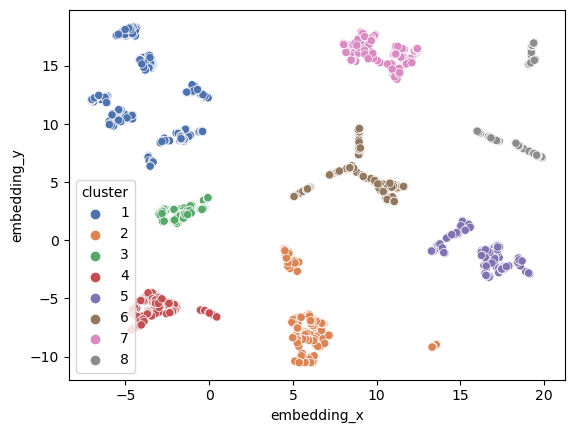

In [183]:
sns.scatterplot( x='embedding_x', y='embedding_y', hue='cluster', data=df9, palette='deep')

## 9.4. Cluster Profile

In [184]:
from datetime import datetime

In [185]:
df92 = df4[cols_selected].copy()
df92['cluster'] = labels

# # change dtypes
# df92['recency_days'] = df92['recency_days'].astype( int )
# df92['qtde_products'] = df92['qtde_products'].astype( int )
# df92['qtde_returns'] = df92['qtde_returns'].astype( int )

# df92['last_training_timestamp'] = datetime.now().strftime( '%Y-%m-%d %H:%M:%S')

In [186]:
df92.head()

,customer_id,gross_revenue,recency_days,qtde_products,frequency,qtde_returns,cluster
0,17850,5391.21,372.0,297.0,17.000000,40.0,7
1,13047,3232.59,56.0,171.0,0.028302,35.0,8
2,12583,6705.38,2.0,232.0,0.040323,50.0,7
3,13748,948.25,95.0,28.0,0.017921,0.0,3
4,15100,876.00,333.0,3.0,0.073171,22.0,1


In [187]:
# Número de clientes em cada cluster
df_cluster = df92[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = 100 * (df_cluster['customer_id'] / df_cluster['customer_id'].sum())

# Média da receita bruta em cada cluster
df_avg_gross_revenue = df92[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_gross_revenue, how='inner', on='cluster')

# Média dos dias de recência em cada cluster
df_avg_recency_days = df92[['recency_days', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_recency_days, how='inner', on='cluster')

# Média de quantidade de produtos
df_qtde_products = df92[['qtde_products', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_qtde_products, how='inner', on='cluster')

# Frequencia media em cada cluster
df_frequency = df92[['frequency', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_frequency, how='inner', on='cluster')

# Media de Retornos em cada cluster
df_qtde_returns = df92[['qtde_returns', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_qtde_returns, how='inner', on='cluster')

df_cluster.sort_values('gross_revenue', ascending=False)

,cluster,customer_id,perc_customer,gross_revenue,recency_days,qtde_products,frequency,qtde_returns
6,7,373,12.567385,10503.060483,19.268097,475.581769,0.110615,187.120643
7,8,240,8.086253,2818.695875,32.658333,192.979167,0.049000,14.450000
5,6,356,11.994609,2404.835787,43.603933,128.373596,0.042313,19.904494
1,2,506,17.048518,2127.020889,58.875494,66.749012,0.048962,16.891304
4,5,404,13.611860,1689.182401,54.801980,89.202970,0.050037,11.542079
3,4,322,10.849057,971.025435,75.329193,37.462733,0.074586,6.571429
2,3,175,5.896226,827.478286,92.022857,26.822857,0.161952,22.868571
0,1,592,19.946092,553.770946,114.917230,14.167230,0.291256,6.538851


## Cluster Analisys - write


### Cluster 1
- **Número de clientes:** 592 (19.95% dos clientes)
- **Receita bruta média:** $553.77
- **Recência média:** 114.92 dias
- **Quantidade média de produtos comprados:** 14.17
- **Frequência média de compras:** 0.2913
- **Quantidade média de devoluções:** 6.54

### Cluster 2
- **Número de clientes:** 506 (17.05% dos clientes)
- **Receita bruta média:** $2,127.02
- **Recência média:** 58.88 dias
- **Quantidade média de produtos comprados:** 66.75
- **Frequência média de compras:** 0.0490
- **Quantidade média de devoluções:** 16.89

### Cluster 3
- **Número de clientes:** 175 (5.90% dos clientes)
- **Receita bruta média:** $827.48
- **Recência média:** 92.02 dias
- **Quantidade média de produtos comprados:** 26.82
- **Frequência média de compras:** 0.1619
- **Quantidade média de devoluções:** 22.87

### Cluster 4
- **Número de clientes:** 322 (10.85% dos clientes)
- **Receita bruta média:** $971.03
- **Recência média:** 75.33 dias
- **Quantidade média de produtos comprados:** 37.46
- **Frequência média de compras:** 0.0746
- **Quantidade média de devoluções:** 6.57

### Cluster 5
- **Número de clientes:** 404 (13.61% dos clientes)
- **Receita bruta média:** $1,689.18
- **Recência média:** 54.80 dias
- **Quantidade média de produtos comprados:** 89.20
- **Frequência média de compras:** 0.0500
- **Quantidade média de devoluções:** 11.54

### Cluster 6
- **Número de clientes:** 356 (11.99% dos clientes)
- **Receita bruta média:** $2,404.84
- **Recência média:** 43.60 dias
- **Quantidade média de produtos comprados:** 128.37
- **Frequência média de compras:** 0.0423
- **Quantidade média de devoluções:** 19.90

### Cluster 7 - **Insiders**
- **Número de clientes:** 373 (12.57% dos clientes)
- **Receita bruta média:** $10,503.06
- **Recência média:** 19.27 dias
- **Quantidade média de produtos comprados:** 475.58
- **Frequência média de compras:** 0.1106
- **Quantidade média de devoluções:** 187.12

### Cluster 8
- **Número de clientes:** 240 (8.09% dos clientes)
- **Receita bruta média:** $2,818.70
- **Recência média:** 32.66 dias
- **Quantidade média de produtos comprados:** 192.98
- **Frequência média de compras:** 0.0490
- **Quantidade média de devoluções:** 14.45

#####  1: Alta Recência
#####  2: Baixa Frequência
#####  3: Baixa Receita
#####  4: Baixa Quantidade de Produtos
#####  5: Média Recência e Frequência
#####  6: Média Receita e Produtos
#####  7: Insiders
#####  8: Alta Recência e Frequência

# 11.0. Deploy To Production

In [188]:
df92.dtypes

customer_id        int64
gross_revenue    float64
recency_days     float64
qtde_products    float64
frequency        float64
qtde_returns     float64
cluster            int32
dtype: object

## 11.1. Insert into SQLITE

In [189]:
import sqlite3
from sqlalchemy import create_engine

In [190]:
df92['recency_days'] = df92['recency_days'].astype(int)
df92['qtde_products'] = df92['qtde_products'].astype(int)
df92['qtde_returns'] = df92['qtde_returns'].astype(int)

In [ ]:
# create table
query_create_table_insiders = """
   CREATE TABLE insiders ( 
       customer_id     INTEGER,
       gross_revenue   REAL,
       recency_days    INTEGER,    
       qtde_products   INTEGER,
       frequency       REAL,
       qtde_returns    INTEGER,
       cluster         INTEGER
   )
"""


conn = sqlite3.connect('insiders_db.sqlite')
conn.execute(query_create_table_insiders)
conn.commit()
conn.close()

# insert data
conn = create_engine('sqlite:///insiders_db.sqlite')
df92.to_sql('insiders', con=conn, if_exists='append', index=False)

# select data

In [192]:
ls -l

total 50080
-rw-rw-r--@ 1 raqueloliveira  staff     5276 Oct 16 09:54 0.0.planning.ipynb
-rw-rw-r--@ 1 raqueloliveira  staff   420819 Oct 17 11:38 1.0.metrics.ipynb
-rw-rw-r--@ 1 raqueloliveira  staff   531718 Nov 27 13:49 10.0.deploy-dataMod.ipynb
-rw-rw-r--@ 1 raqueloliveira  staff   105261 Dec  5 13:40 11.0.deployFinal.ipynb
-rw-rw-r--@ 1 raqueloliveira  staff   768721 Oct 17 16:54 2.0.metrics.ipynb
-rw-rw-r--@ 1 raqueloliveira  staff   710272 Oct 18 14:52 3.0.metrics.ipynb
-rw-rw-r--@ 1 raqueloliveira  staff  1903721 Nov  6 11:21 4.0.feature-engineering.ipynb
-rw-rw-r--@ 1 raqueloliveira  staff  2773948 Nov  6 13:37 5.0.clustering-modeling.ipynb
-rw-rw-r--@ 1 raqueloliveira  staff  2713349 Nov 13 13:31 6.0.model-performance.ipynb
-rw-rw-r--@ 1 raqueloliveira  staff  1867818 Nov 14 18:49 7.0.model-result.ipynb
-rw-rw-r--@ 1 raqueloliveira  staff  2738347 Nov 16 11:52 8.0.eda.ipynb
-rw-rw-r--@ 1 raqueloliveira  staff   401855 Nov 27 14:32 9.0.deploy.ipynb
-rw-r--r--  1 raqueloliveira

In [193]:
# consulting database
query = """
    SELECT * FROM insiders 
"""

df = pd.read_sql_query(query, conn)

In [194]:
df.head()

,customer_id,gross_revenue,recency_days,qtde_products,frequency,qtde_returns,cluster
0,17850,5391.21,372,297,17.000000,40,7
1,13047,3232.59,56,171,0.028302,35,8
2,12583,6705.38,2,232,0.040323,50,7
3,13748,948.25,95,28,0.017921,0,3
4,15100,876.00,333,3,0.073171,22,1


In [ ]:
df.shape

(2968, 7)